In [16]:
%matplotlib widget
import gudhi as gd
from gudhi import hera
from gudhi import representations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import sklearn
from sklearn import manifold
from sklearn_extra.cluster import KMedoids
from sklearn.svm import SVC
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.neighbors       import KNeighborsClassifier
from tqdm.notebook import tqdm
import scipy.optimize as spo 
from scipy.optimize import minimize
import kmedoids

import os
import math
import time

In [17]:

def diag_to_array(data):
    dataset, num_diag = [], len(data["0"].keys())
    for dim in data.keys():
        X = []
        for diag in range(num_diag):
            pers_diag = np.array(data[dim][str(diag)])
            X.append(pers_diag)
        dataset.append(X)
    return dataset

def diag_to_dict(D):
    X = dict()
    for f in D.keys():
        df = diag_to_array(D[f])
        for dim in range(len(df)):
            X[str(dim) + "_" + f] = df[dim]
    return X 

In [18]:
path = "../sklearn-tda/example/3DSeg/"
train_lab  = pd.read_csv(path+"train.csv")
train_diag = diag_to_dict(h5py.File(path+"train_diag.hdf5", "r"))

In [19]:
from sklearn.preprocessing import LabelEncoder

# Size of test set
test_size = 0.8

# Shuffle dataset and pick points for test set
train_num_pts        = train_lab.shape[0]    
perm                 = np.random.RandomState(seed=42).permutation(train_num_pts)
limit                = np.int(test_size * train_num_pts)
test_sub, train_sub  = perm[:limit], perm[limit:]

# Create train and test labels with LabelEncoder from scikit-learn
train_full_labels  = train_lab["part"]
le                 = LabelEncoder()
train_labels       = np.array(le.fit_transform(train_full_labels[train_sub]))
test_labels        = np.array(le.transform(train_full_labels[test_sub]))

# Create train and test sets of persistence diagrams
train_full_diag    = train_diag["1_geodesic"]
train_diag         = [train_full_diag[i] for i in train_sub]
test_diag          = [train_full_diag[i] for i in test_sub]

# Print sizes
train_num_pts, test_num_pts = len(train_sub), len(test_sub)
print("Number of train points = " + str(train_num_pts))
print("Number of test  points = " + str(test_num_pts))
print(perm)

Number of train points = 1140
Number of test  points = 4560
[1436  748 4596 ... 5226 5390  860]


/tmp/ipykernel_5908/674343841.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  limit                = np.int(test_size * train_num_pts)


mean 11.853508771929825
std 4.8930254663996315


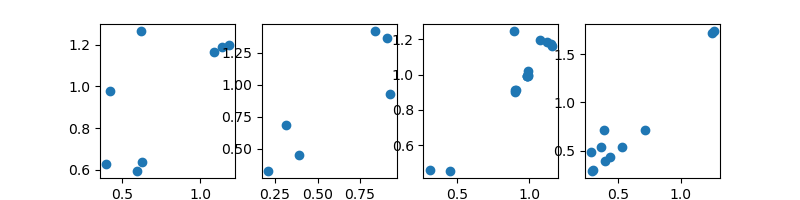

In [20]:
print("mean",np.mean([len(pd) for pd in test_diag]))
print("std", np.std([len(pd) for pd in test_diag]))
f, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(8,2))
ax1.scatter(train_diag[1][:,0],train_diag[1][:,1])
ax2.scatter(train_diag[3][:,0],train_diag[3][:,1])
ax3.scatter(train_diag[38][:,0],train_diag[38][:,1])
ax4.scatter(train_diag[0][:,0],train_diag[0][:,1])

plt.show()


In [21]:
persistence_list_by_shapes = [np.array(train_diag)[train_labels==i] for i in range(0,4)] 

/tmp/ipykernel_5908/427703180.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  persistence_list_by_shapes = [np.array(train_diag)[train_labels==i] for i in range(0,4)]


In [22]:
len(persistence_list_by_shapes[2])

102

In [32]:
xs = np.linspace(0,0.5,101)
bp_vals = [[[] for y in range(4)] for z in range(4)]

for i in range(0,4):
    for j in range(i,4):
        index=0
        print(i,j)
        for k in tqdm(range(0, len(persistence_list_by_shapes[i]))):
            for l in range(0,len(persistence_list_by_shapes[j])):
                bp_vals[i][j].append(np.array([gd.bottleneck_profile(persistence_list_by_shapes[i][k],persistence_list_by_shapes[j][l],t) for t in  xs]))


0 0


  0%|          | 0/482 [00:00<?, ?it/s]

0 1


  0%|          | 0/482 [00:00<?, ?it/s]

0 2


  0%|          | 0/482 [00:00<?, ?it/s]

0 3


  0%|          | 0/482 [00:00<?, ?it/s]

1 1


  0%|          | 0/416 [00:00<?, ?it/s]

1 2


  0%|          | 0/416 [00:00<?, ?it/s]

1 3


  0%|          | 0/416 [00:00<?, ?it/s]

2 2


  0%|          | 0/102 [00:00<?, ?it/s]

2 3


  0%|          | 0/102 [00:00<?, ?it/s]

3 3


  0%|          | 0/140 [00:00<?, ?it/s]

In [51]:
mean_bpvals_array

[[array([1.44605120e+01, 6.71791550e+00, 6.23217145e+00, 5.91058608e+00,
         5.66974140e+00, 5.41366798e+00, 5.25376199e+00, 5.11603192e+00,
         4.85111310e+00, 4.62048260e+00, 4.35682065e+00, 4.14699730e+00,
         3.96681359e+00, 3.76281400e+00, 3.60445326e+00, 3.41037086e+00,
         3.27469827e+00, 3.12798075e+00, 3.02492209e+00, 2.96061965e+00,
         2.89429848e+00, 2.77112997e+00, 2.61188685e+00, 2.52136671e+00,
         2.31757373e+00, 2.18781099e+00, 2.07338889e+00, 1.97174205e+00,
         1.86231728e+00, 1.74976326e+00, 1.67234982e+00, 1.60034262e+00,
         1.53627692e+00, 1.46368003e+00, 1.40193867e+00, 1.33808819e+00,
         1.26855598e+00, 1.19642396e+00, 1.12579845e+00, 1.04195864e+00,
         9.90922160e-01, 9.38844028e-01, 8.91259620e-01, 8.44712557e-01,
         8.02839999e-01, 7.55556895e-01, 7.27974725e-01, 7.02144419e-01,
         6.72814690e-01, 6.48434944e-01, 6.19707822e-01, 5.81786643e-01,
         5.57251941e-01, 5.29226425e-01, 4.91795940

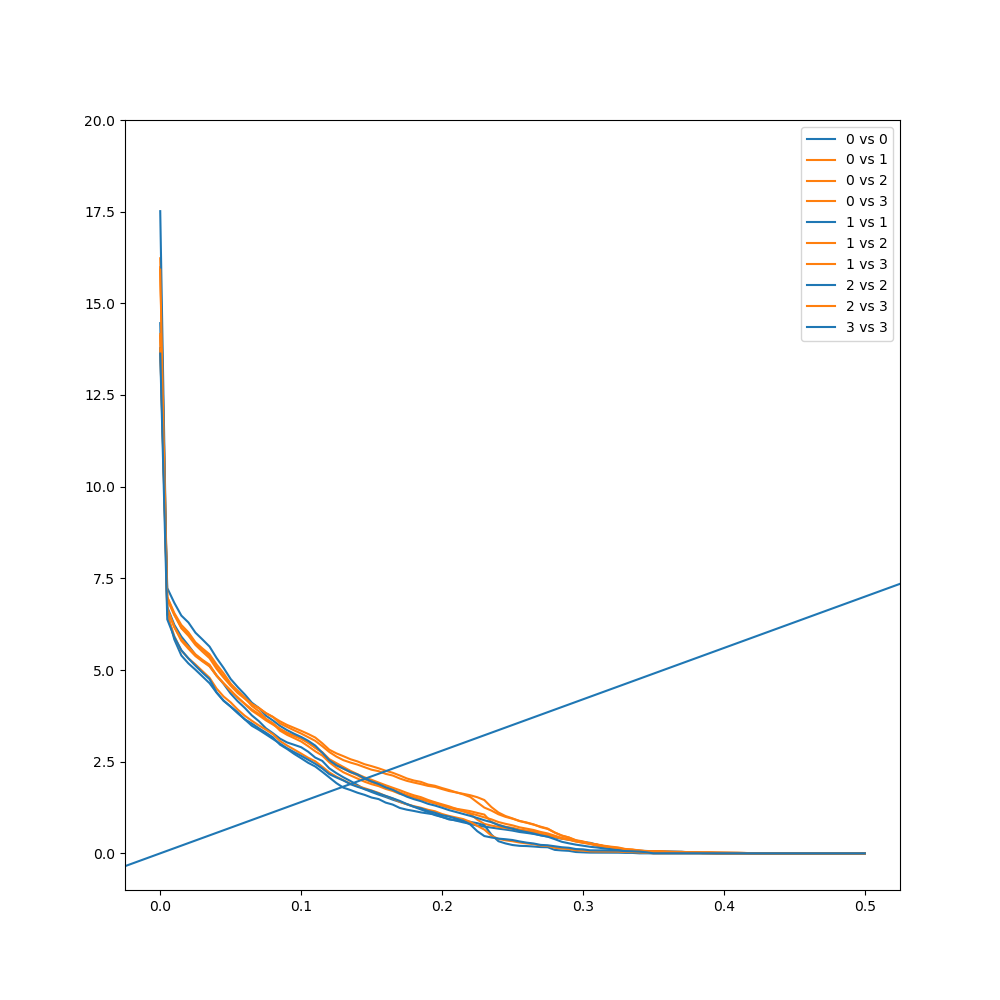

In [55]:
fig,ax = plt.subplots(figsize = (10,10))
mean_bpvals_array = [[[]]*4]*4
for i in range(0,4):
    for j in range(i,4):
        Dmean = np.mean(bp_vals[i][j], axis = 0)
        mean_bpvals_array[i][j] = Dmean
        #Dstd = np.array([np.std([D(r,t) for r in r_vals[i][j]]) for t in ts])
        col = "tab:blue" if i==j else "tab:orange"
        #plt.errorbar(ts,Dmean,Dstd, linestyle='None', marker='o', c=col, ms = 2, label = "{} vs {}".format(i,j))
        plt.plot(xs,Dmean, c=col, label = "{} vs {}".format(i,j))
        
#plt.plot(ts,25*ts**2, c='k', ls='--', label="$25 t^2$")
#plt.plot(ts,5*ts, c='k', ls='--', label="$5t$")
#plt.plot(ts,12*ts +12*ts**2, c='k', ls='--', label="$12t^2+12t$")

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc="upper right")

plt.gca().set_ylim((-1,20))

ax.axline((0,0), slope = 14)
#plt.plot(ts,np.log(141)*ts+np.log(141)/2**2*ts**2+np.log(141)/6**3*ts**3+np.log(141)/24**4*ts**4, color='grey', ls='--')

plt.show()

In [35]:
def intersection_locus(bp, slope):
    #return xs[np.argwhere(np.diff(np.sign(bp-f))).flatten()][0]
    idx0 = np.argwhere(np.diff(np.sign(bp-slope*xs))).flatten()[0]
    x = (bp[idx0]+xs[idx0]*(bp[idx0]-bp[idx0+1]))/(slope + bp[idx0]-bp[idx0+1]) 
    return x

In [36]:
def score_linear_function(slope, inter, intra):
    score = 1
    inter_dists = [intersection_locus(bp, slope) for bp in inter]
    intra_dists = [intersection_locus(bp, slope) for bp in intra]
    #score = np.sum(intra_dists)/len(intra_dists) - np.sum(inter_dists)/len(inter_dists)
    score = np.max(intra_dists)/ np.min(inter_dists)
    #diffs = [intra_dists[i] - inter_dists[j] for i in range(0,len(intra_dists)) for j in range(0,len(inter_dists))]
    #score = np.mean(diffs)
    return score

In [52]:

inter_cluster_bp = [mean_bpvals_array[i][i] for i in range(0,4)]
intra_cluster_bp = [mean_bpvals_array[i][j] for j in range(0,i) for i in range(0,4)]

In [53]:
minval = 999999
minidx = 0
for s in tqdm(range(10,2000)):
    score = score_linear_function(s, inter_cluster_bp, intra_cluster_bp)
    if score <= minval:
        minval = score
        minidx = s
        
print(minidx, minval)

  0%|          | 0/1990 [00:00<?, ?it/s]

14 1.0688550189286645


In [56]:
minimize(score_linear_function, x0 = 14, args=(inter_cluster_bp, intra_cluster_bp), method="Nelder-Mead")

 final_simplex: (array([[14.11193848],
       [14.11185303]]), array([1.06883208, 1.0688321 ]))
           fun: 1.0688320830123146
       message: 'Optimization terminated successfully.'
          nfev: 41
           nit: 19
        status: 0
       success: True
             x: array([14.11193848])

In [57]:
l = len(train_diag)
#base = 9
#coefs = [np.log(base)**k/math.factorial(k) for k in range(1,11)]
#coefs = np.array([0]+coefs)
coefs = np.array([0,14])
P1 = np.zeros((l,l))
B1 = np.zeros((l,l))
W1 = np.zeros((l,l))
W2 = np.zeros((l,l))
coefs = np.array([0,12,12])
tic = time.time()
for i in range(l):
    diag1 = train_diag[i]
    for j in range(i):
        P1[i,j] = gd.prokhorov_distance(diag1, train_diag[j], coefs)
        B1[i,j] = gd.bottleneck_distance(train_diag[i], train_diag[j] )
        W1[i,j] = gd.hera.wasserstein_distance(train_diag[i], train_diag[j], order=1, internal_p=1)
        W2[i,j] = gd.hera.wasserstein_distance(train_diag[i], train_diag[j], order=2, internal_p=2)
P1 = P1 + P1.transpose()
B1 = B1 + B1.transpose()
W1 = W1 + W1.transpose()
W2 = W2 + W2.transpose()
print(time.time()-tic)

793.0097012519836


In [58]:
from sklearn.preprocessing   import MinMaxScaler
from sklearn.pipeline        import Pipeline
from sklearn.svm             import SVC
from sklearn.ensemble        import RandomForestClassifier
from sklearn.neighbors       import KNeighborsClassifier

# Definition of pipeline
pipe = Pipeline([("Separator", gd.representations.DiagramSelector(limit=np.inf, point_type="finite")),
                 ("Scaler",    gd.representations.DiagramScaler(scalers=[([0,1], MinMaxScaler())])),
                 ("TDA",       gd.representations.PersistenceImage()),
                 ("Estimator", SVC())])

# Parameters of pipeline. This is the place where you specify the methods you want to use to handle diagrams
param =    [{"Scaler__use":         [False],
             "TDA":                 [gd.representations.ProkhorovDistance()], 
             "TDA__n_jobs":         [1],
             "TDA__coefs":          [np.array([0,i,j]) for i in range(0,15) for j in range(0,25)], 
             "Estimator":           [KNeighborsClassifier(metric="precomputed")]}
           ]

In [59]:
from sklearn.model_selection import GridSearchCV

model = GridSearchCV(pipe, param, cv=3, verbose = 4)

In [60]:
model = model.fit(train_diag, train_labels)

Fitting 3 folds for each of 375 candidates, totalling 1125 fits
[CV 1/3] END Estimator=KNeighborsClassifier(metric='precomputed'), Scaler__use=False, TDA=ProkhorovDistance(), TDA__coefs=[0 0 0], TDA__n_jobs=1;, score=0.850 total time= 2.6min
[CV 2/3] END Estimator=KNeighborsClassifier(metric='precomputed'), Scaler__use=False, TDA=ProkhorovDistance(), TDA__coefs=[0 0 0], TDA__n_jobs=1;, score=0.811 total time= 1.6min
[CV 3/3] END Estimator=KNeighborsClassifier(metric='precomputed'), Scaler__use=False, TDA=ProkhorovDistance(), TDA__coefs=[0 0 0], TDA__n_jobs=1;, score=0.826 total time= 1.7min
[CV 1/3] END Estimator=KNeighborsClassifier(metric='precomputed'), Scaler__use=False, TDA=ProkhorovDistance(), TDA__coefs=[0 0 1], TDA__n_jobs=1;, score=0.850 total time= 1.7min
[CV 2/3] END Estimator=KNeighborsClassifier(metric='precomputed'), Scaler__use=False, TDA=ProkhorovDistance(), TDA__coefs=[0 0 1], TDA__n_jobs=1;, score=0.811 total time= 1.7min
[CV 3/3] END Estimator=KNeighborsClassifier(me

KeyboardInterrupt: 

In [58]:
print(model.best_params_)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [61]:
def kmedoids_score(distance_matrix, train_labels):
    c = kmedoids.fasterpam(distance_matrix, len(np.unique(train_labels)), init="build")       
    return sum([train_labels[i] == train_labels[c.medoids[c.labels[i]]] for i in range(0,len(train_labels))])/len(train_labels)

In [62]:
def score_metric(coefs):
    #tic = time.time()
    #PP = sklearn.metrics.pairwise_distances(train_diag, metric = gd.prokhorov_distance, n_jobs=-1, coefs = np.array([6.91132459e-04, 1.10974319e+00, 1.10546464e+01]))
    #BW = sklearn.metrics.pairwise_distances(train_diag, metric = gd.bottleneck_distance, n_jobs=-1)
    PD = gd.representations.ProkhorovDistance(n_jobs = -1, coefs=coefs)
    PD.fit(train_diag)
    pm = PD.transform(train_diag)
    #print(time.time()-tic)
    #clf = KNeighborsClassifier(metric="precomputed")
    #scores = cross_val_score(clf, pm, train_labels, cv=3)
    #print(scores)
    #return(-scores.mean())
    return(-metrics.silhouette_score(pm, train_labels, metric='precomputed'))
    #return -kmedoids_score(pm, train_labels)

In [63]:
cur_best = 1
best_i = 0
best_j =0
for i in range(0,15,1):
    for j in range(0,25-i,1):
        tic=time.time()
        score = score_metric(np.array([0,i,j]))
        print(i,j, score, "time: ", time.time()-tic)
        if score<cur_best:
            cur_best = score
            best_i = i
            best_j = j
            
print("best", best_i, best_j, cur_best)

0 0 0.00882891951487949 time:  68.7795295715332
0 1 0.00882891951487949 time:  69.6097993850708
0 2 0.00882891951487949 time:  72.60475540161133


KeyboardInterrupt: 

In [64]:
res = minimize(score_metric, np.array([0,14]), method='Nelder-Mead', tol=1e-6)
res

KeyboardInterrupt: 

In [65]:
coefs = np.array([0,14])#res.x
print(coefs)

[ 0 14]


In [66]:
tic = time.time()
PD = gd.representations.ProkhorovDistance(n_jobs = -1, coefs=coefs)
PD.fit(train_diag)
pm = PD.transform(test_diag)
print("Prokhorov done in ",time.time()-tic)

Prokhorov done in  262.4600565433502


In [67]:
tic = time.time()
BD = gd.representations.BottleneckDistance(n_jobs = -1)
BD.fit(train_diag)
bd = BD.transform(test_diag)
print("Bottleneck done in ",time.time()-tic)

tic = time.time()
WD1 = gd.representations.WassersteinDistance(n_jobs = -1, internal_p=1, order=1)
WD1.fit(train_diag)
wd1 = WD1.transform(test_diag)
print("1-Wasserstein done in ",time.time()-tic)

tic = time.time()
WD2 = gd.representations.WassersteinDistance(n_jobs = -1, internal_p=2, order=2)
WD2.fit(train_diag)
wd2 = WD2.transform(test_diag)
print("2-Wasserstein done in ",time.time()-tic)

Bottleneck done in  493.9187512397766
1-Wasserstein done in  259.9705834388733
2-Wasserstein done in  711.9727132320404


In [68]:

clf = KNeighborsClassifier(metric="precomputed")
#clf = SVC(kernel="precomputed")
clf.fit(P1, train_labels)
print("Prokhorov score ",clf.score(pm,test_labels))

clf.fit(B1, train_labels)
print("Bottleneck score ",clf.score(bd,test_labels))

clf.fit(W1, train_labels)
print("1-Wasserstein score ",clf.score(wd1,test_labels))

clf.fit(W2, train_labels)
print("2-Wasserstein score ",clf.score(wd2,test_labels))

Prokhorov score  0.8239035087719299
Bottleneck score  0.8519736842105263
1-Wasserstein score  0.8673245614035088
2-Wasserstein score  0.868421052631579


In [69]:
tic = time.time()
PD = gd.representations.ProkhorovDistance(n_jobs = -1, coefs=coefs)
PD.fit(test_diag)
pm = PD.transform(test_diag)
print("Prokhorov done in ",time.time()-tic)

tic = time.time()
BD = gd.representations.BottleneckDistance(n_jobs = -1)
BD.fit(test_diag)
bd = BD.transform(test_diag)
print("Bottleneck done in ",time.time()-tic)

tic = time.time()
WD1 = gd.representations.WassersteinDistance(n_jobs = -1, internal_p=1, order=1)
WD1.fit(test_diag)
wd1 = WD1.transform(test_diag)
print("1-Wasserstein done in ",time.time()-tic)

tic = time.time()
WD2 = gd.representations.WassersteinDistance(n_jobs = -1, internal_p=2, order=2)
WD2.fit(test_diag)
wd2 = WD2.transform(test_diag)
print("2-Wasserstein done in ",time.time()-tic)

Prokhorov done in  1198.0630905628204
Bottleneck done in  1441.1707253456116
1-Wasserstein done in  1243.020146369934
2-Wasserstein done in  1924.3985753059387


In [70]:
print("Prokhorov score", metrics.silhouette_score(pm, test_labels, metric='precomputed'))
print("Bottleneck score", metrics.silhouette_score(bd, test_labels, metric='precomputed'))
print("1-Wasserstein score", metrics.silhouette_score(wd1, test_labels, metric='precomputed'))
print("2=Wasserstein score", metrics.silhouette_score(wd2, test_labels, metric='precomputed'))

Prokhorov score -0.008796473532674329
Bottleneck score -0.006830069248563079
1-Wasserstein score -0.030656917722281265
2=Wasserstein score -0.026536414387256135


In [71]:
print("Prokhorov score", kmedoids_score(pm, test_labels))
print("Bottleneck score", kmedoids_score(bd, test_labels))
print("1-Wasserstein score", kmedoids_score(wd1, test_labels))
print("2=Wasserstein score", kmedoids_score(wd2, test_labels))

Prokhorov score 0.48092105263157897
Bottleneck score 0.5105263157894737
1-Wasserstein score 0.40657894736842104
2=Wasserstein score 0.4635964912280702
